# Stereoisomer testing on ChiENN - axiale chiralität

## Importing section

In [1]:
import sys

import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import AllChem

from ptgnn.model.modules.custom_wrapper import CustomWrapper

sys.path.append("../../../../")

from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer
from ptgnn.transform import edge_graph_transform, vertex_graph_transform
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.loading.chienn_collate import collate_with_circle_index

## Define SMILES strings

In [2]:
smiles_list = [
    "C(C(=O)O)1=CC=CC(N(O)O)=C1C2=C(N(O)O)C=CC=C(C(=O)O)2",
    "C(C(=O)O)1=CC=CC(N(O)O)=C1C2=C(C(=O)O)C=CC=C(N(O)O)2",
    "C(N(O)O)1=CC=CC(C(=O)O)=C1C2=C(N(O)O)C=CC=C(C(=O)O)2",
    "C(N(O)O)1=CC=CC(C(=O)O)=C1C2=C(C(=O)O)C=CC=C(N(O)O)2",
    
    "C(C(=O)O)1C=CC=C(N(O)O)C=1\C2/C(N(O)O)=CC=CC(C(=O)O)=2",
    "C(C(=O)O)1C=CC=C(N(O)O)C=1\C2/C(C(=O)O)=CC=CC(N(O)O)=2",
    "C(N(O)O)1C=CC=C(C(=O)O)C=1\C2/C(N(O)O)=CC=CC(C(=O)O)=2",
    "C(N(O)O)1C=CC=C(C(=O)O)C=1\C2/C(C(=O)O)=CC=CC(N(O)O)=2",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

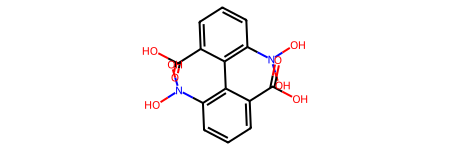

[]
Bond 1 stereo: STEREONONE
Bond 21 stereo: STEREONONE


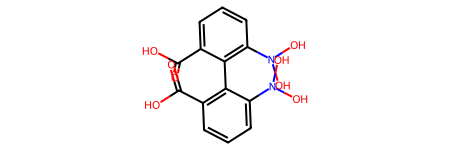

[]
Bond 1 stereo: STEREONONE
Bond 14 stereo: STEREONONE


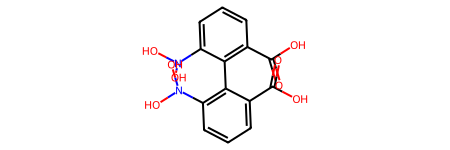

[]
Bond 8 stereo: STEREONONE
Bond 21 stereo: STEREONONE


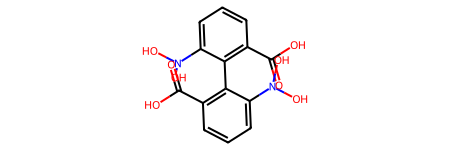

[]
Bond 8 stereo: STEREONONE
Bond 14 stereo: STEREONONE


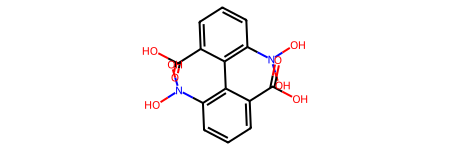

[]
Bond 1 stereo: STEREONONE
Bond 21 stereo: STEREONONE


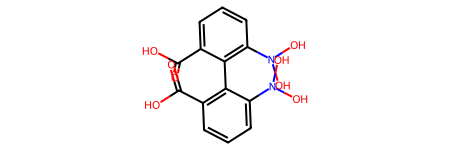

[]
Bond 1 stereo: STEREONONE
Bond 14 stereo: STEREONONE


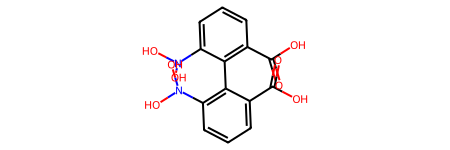

[]
Bond 8 stereo: STEREONONE
Bond 21 stereo: STEREONONE


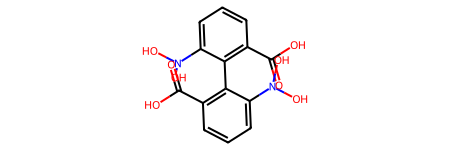

[]
Bond 8 stereo: STEREONONE
Bond 14 stereo: STEREONONE


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    vertex_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'cis_trans_edges': True,
            'axial_chirality': False
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
for data in data_list:
    # print(data)
    print(data.ptree)

['{"S": [0, {"P": [1]}]}', '{"S": [1, {"P": [0, 2, 3]}]}', '{"S": [2, {"P": [1, 24]}]}', '{"S": [3, {"P": [1, 4, 11]}]}', '{"S": [4, {"P": [3, 5, 25]}]}', '{"S": [5, {"P": [4, 6, 26]}]}', '{"S": [6, {"P": [5, 7, 27]}]}', '{"S": [7, {"P": [6, 8, 11]}]}', '{"S": [8, {"P": [7, 9, 10]}]}', '{"S": [9, {"P": [8, 28]}]}', '{"S": [10, {"P": [8, 29]}]}', '{"S": [11, {"P": [3, 7, 12]}]}', '{"S": [12, {"P": [11, 13, 20]}]}', '{"S": [13, {"P": [12, 14, 17]}]}', '{"S": [14, {"P": [13, 15, 16]}]}', '{"S": [15, {"P": [14]}]}', '{"S": [16, {"P": [14, 30]}]}', '{"S": [17, {"P": [13, 18, 31]}]}', '{"S": [18, {"P": [17, 19, 32]}]}', '{"S": [19, {"P": [18, 20, 33]}]}', '{"S": [20, {"P": [12, 19, 21]}]}', '{"S": [21, {"P": [20, 22, 23]}]}', '{"S": [22, {"P": [21, 34]}]}', '{"S": [23, {"P": [21, 35]}]}', '{"S": [24, {"P": [2]}]}', '{"S": [25, {"P": [4]}]}', '{"S": [26, {"P": [5]}]}', '{"S": [27, {"P": [6]}]}', '{"S": [28, {"P": [9]}]}', '{"S": [29, {"P": [10]}]}', '{"S": [30, {"P": [16]}]}', '{"S": [31, {"P

All elements are Z(x,y) which is equivalent to P(x,y) which means distinguishing is not possible

## Create Model

In [9]:
k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=43,
        k=k
    ))
    for _ in range(2)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=43,
        k=k
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=43, out_features=43, bias=False)
      (p_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=43, out_features=43, bias=False)
      )
      (z_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=43, out_features=43, bias=False)
      )
      (s_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (elu): ELU(alpha=1.0)
      (batch_norm): BatchNorm1d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=43, out_features=43, bias=False)
      (p_final_layer): Linear(in_features=43, out_features=43, bias=False)
      (z_layer): ModuleList(
        (0-2): 3 x Li

## Create batches

In [10]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

## Put batches through model

In [11]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [12]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else False
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [13]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [14]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

All batches equal and full invariance